In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from random import randrange
import math
import time

#read in csv file with wind data
df = pd.read_csv('dly2175.csv', skiprows = 24)

 
df = df[['date', 'wdsp']]       #only columns we are interested in are the date and wind speed
df = df.set_index('date')
df = df.squeeze(axis = 0)       #convert into Pandas series object
df['wdsp'] = pd.to_numeric(df['wdsp'], errors = 'coerce')       #ensure data is in correct format

df['wdsp'] = df ['wdsp'] * 0.51444444444        #convert into m/s
df.head()

,wdsp
date,
01-Jan-50,5.093000
02-Jan-50,8.488333
03-Jan-50,5.247333
04-Jan-50,3.601111
05-Jan-50,5.247333


<AxesSubplot:xlabel='date'>

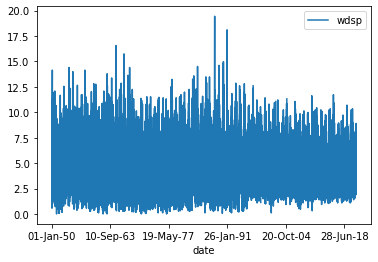

In [30]:
#data exploration and visualisation
df.plot()

<AxesSubplot:ylabel='Count'>

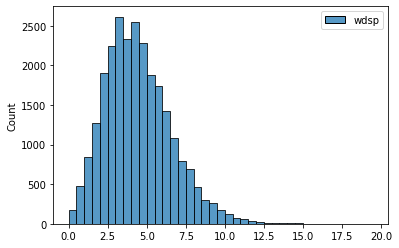

In [24]:
sns.histplot(data = df, binwidth = 0.5)

In [7]:
#defines main class of this script for pricing parametric weather insurance
class InsurancePolicy:

    def __init__ (self, strike, amount, data = 0, high_or_low = 'Lower', consec_days = 1,
                    n = 5000, tr = 0.2):

        #initialise a list to store annual probabilities of a day having a value of lower/higher than the strike
        p = []
        
        #calculate these probabilities by sampling the data at random points n times
        for i in range(n):
            start = randrange(len(data) - 365)
            w = data.iloc[start : start + 365]      #creates a pandas.Series object for the random year chosen
            
            if high_or_low == 'Lower':
                w = w < strike              #replaces every value in w with True if its less than the strike (else False)
            elif high_or_low == 'Higher':
                w = w > strike              #replaces every value in w with True if its greater than the strike (else False)

            #this loop handles the consecutive days input and only leaves values 
            #as True if there are <consec_days> number of True values in a row
            for i in range(366-consec_days):

                if w[i-1] == True and i != 0:
                    continue

                vec = []
                for j in range(consec_days):
                    vec.append(w[i+j])

                if all(vec) == True:
                    w[i] = True
                else:
                    w[i] = False
            
            p.append(np.sum(w)/len(w))          #calculates the yearly probability and adds it to the list
        
        prob = np.mean(np.array(p))             #calculates average probability
        r = (tr*(max(p)-prob))/(prob*(1+tr))    #calculates a correction factor (r) that is used in the premium calculation to ensure target return is achieved
        
        retrn = (r*prob) / (max(p) - prob - r*prob)     #actual return value is calculated to ensure it is not too far from target
        prem = prob * amount * 365 * (1+r)              #premium is calculated as the amount needed to cover the average year of payouts multiplied by the correction factor (r)
        collat = (max(p) * amount * 365) - prem         #collateral required is the amount necessary to cover the payouts in the wors year in the data
        
        prof_loss = []              #initialise list to store yearly percentage pnl values
        sim = [collat]              #initialise list to store value of investment
        
        #calculate yearly pnl values and cumulative investment value
        for i in range(len(p)):
            sim.append (sim[i] + prem - (p[i]*amount*365))
            prof_loss.append((prem - (p[i] * amount *365)) / collat)
        
        #calculate sharpe ratio
        sd = np.std(np.array(prof_loss))
        sharpe = retrn/sd

        #these properties are the important ones required by the user
        self.premium = prem
        self.collat = collat
        self.sharpe = sharpe

        #these properties are to allow the simulate() func to access the necessary data to perform the simulation or for debugging
        self.prof_loss = prof_loss
        self.sim = sim
        self.prob_vec = p
        self.retrn = retrn
        
        #error handling
        if collat < 0:
            raise ValueError

    #function that produces graphs based on the returns of the generated policy
    def simulate(self, sim_type, sim_start = 0, sim_end = 20):

        #shows distribution of returns for the policy
        if sim_type == 'dist':
            return sns.histplot(data = self.prof_loss, binwidth = 0.1)

        #shows cumulative returns for the policy for the specified years    
        elif sim_type == 'cumul':
            xvec = np.arange(len(self.prob_vec)+1)
            sns.lineplot(x = xvec, y = self.sim)
            plt.xlim(sim_start, sim_end)
            plt.xlabel('Years')
            plt.ylabel('Investment Value')
            
            #handles when the investement value becomes negative
            if min(self.sim[sim_start : sim_end]) < 0:
                plt.ylim(min(self.sim[sim_start : sim_end+1])-300000, max(self.sim[sim_start : sim_end+1])+300000)
            else:
                plt.ylim(0, max(self.sim[sim_start : sim_end])+300000)

Premium: 346597 
Collateral: 633403 
Sharpe Ratio: 0.54


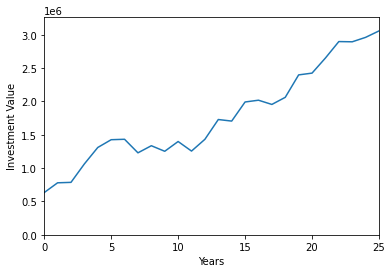

In [33]:
#shows a typical insurance policy and the simulated returns on it
pol = InsurancePolicy(3, 10000, data = df, consec_days = 5, tr = 0.15)
print(f'Premium: {round(pol.premium)} \nCollateral: {round(pol.collat)} \nSharpe Ratio: {round(pol.sharpe, 2)}')
pol.simulate('cumul', sim_end = 25)

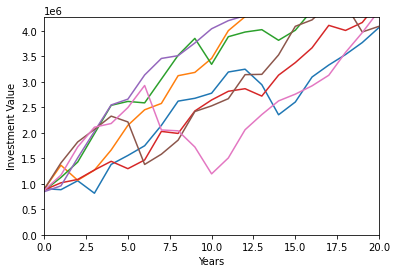

In [11]:
#shows multiple instances of a policy with the same parameters but starting at different years to illustrate volatility of returns
for i in range(7):
    p = InsurancePolicy(3, 15000, data = df, consec_days = 5)
    p.simulate('cumul')

In [14]:
#shows relationship between <consec_days> parameter and premium
i = []
j = []

for x in range(1,10):
    j.append(InsurancePolicy(3, 5000, data = df, n = 2000, consec_days = x).premium)
    i.append(x)

(0.0, 575783.4375000001)

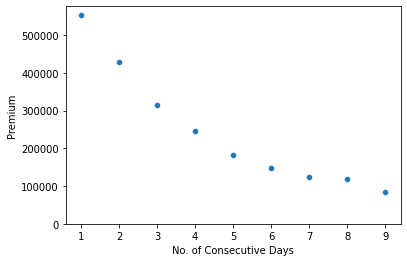

In [15]:
sns.scatterplot(x=i, y=j)
plt.xlabel('No. of Consecutive Days')
plt.ylabel('Premium')
plt.ylim(bottom=0)